In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import requests
import re
from copy import deepcopy
from sklearn.decomposition import PCA
from numpy import savetxt, loadtxt
from scipy.stats import ranksums,mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection
import graphviz
from scipy.stats import rankdata,spearmanr,pearsonr
from sklearn.linear_model import LogisticRegression
from scipy.special import logit
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed

In [2]:
from matplotlib import style
import seaborn as sns
import statsmodels.formula.api as smf

import graphviz as gr

%matplotlib inline

style.use("fivethirtyeight")
pd.set_option("display.max_columns", 6)

In [3]:
def pie(df, col, numerical=False, label_dict=None):
    val_lst = list(df[col])
    if numerical:
        try:
            temp = [int(x) for x in val_lst if x not in ["'--","Unknown",'Not Reported','not reported',np.nan]]
        except:
            temp = [float(x) for x in val_lst if x not in ["'--","Unknown",'Not Reported','not reported',np.nan]]
        val_lst = temp+(len(val_lst)-len(temp))*[np.nan]
        labels = sorted(set(val_lst))
    else:
        labels = sorted(set(val_lst))
    sizes = []
    for l in labels:
        sizes.append(val_lst.count(l))
    plt.figure(figsize=(10,10))
    if label_dict is not None:
        labels = [label_dict[l] for l in labels]
    plt.pie(x=sizes, labels=labels, autopct=lambda p : '{:.2f}%  ({:,.0f})'.format(p,p * sum(sizes)/100))


In [4]:
target_list_symbols_file_name = 'hsapiens_gene_names.csv'
target_list_symbols = pd.read_csv(target_list_symbols_file_name, index_col=0)

In [5]:
def add_gene_names(table):
    table['ENSG'] = [x[:x.find('.')] for x in table.index]
    table = pd.merge(table,target_list_symbols,how='left',left_on='ENSG',right_index=True)
    table = table[['external_gene_name']+list(table.columns[:-1])]
    table = table.drop('ENSG', axis=1)
    return table

In [6]:
# gene expression counts
counts_per_million_file = '../results/normal_samples_only/counts_per_million.txt'
counts_per_million = pd.read_csv(counts_per_million_file, index_col=0)
counts_per_million

,f20559be-0cc8-458b-b334-2ad0bb135445,fb21e40b-471d-4f53-bd98-0d2de2299060,f5271413-a40a-46a6-bb54-d5e5a66925af,...,70510e82-3d1e-4fb4-a2a1-7200bebcde16,7f0157b9-81cc-478a-9cd1-d734e8fa7584,897d7567-fc0b-466b-be8c-94f9df07b5bc
ENSG00000000003.13,21.610605,16.791261,21.643253,...,13.611743,25.623348,26.401527
ENSG00000000005.5,0.318976,0.317739,0.119083,...,0.339687,0.320292,0.184465
ENSG00000000419.11,24.454805,35.024566,28.728665,...,21.982601,20.632133,23.565380
ENSG00000000457.12,29.372348,23.879275,19.202061,...,21.400280,32.296095,22.251068
ENSG00000000460.15,8.452857,6.501420,5.090779,...,5.993049,8.247515,8.070336
...,...,...,...,...,...,...,...
ENSG00000281910.1,0.000000,0.000000,0.029771,...,0.000000,0.000000,0.000000
ENSG00000281912.1,0.478464,0.439946,0.535871,...,0.436740,0.453747,0.484220
ENSG00000281918.1,0.664533,0.439946,0.535871,...,0.388214,0.613893,0.322813
ENSG00000281920.1,0.212650,0.171090,0.148853,...,0.218370,0.186837,0.184465


In [7]:
# wilcoxon table
wilcoxon_table_file = '../results/normal_samples_only/wilcoxon_smoking_status_2_vs_others.txt'
#wilcoxon_table.to_csv(wilcoxon_table_file)
wilcoxon_table = pd.read_csv(wilcoxon_table_file, index_col=0)
wilcoxon_table

,external_gene_name,wrs,wrs_pvalue,...,FDR_0.05,FDR_0.1,FDR_0.15
ENSG00000063438.15,AHRR,7.503560,6.210734e-14,...,True,True,True
ENSG00000171658.7,NMRAL2P,6.444234,1.161855e-10,...,True,True,True
ENSG00000131981.14,LGALS3,6.187946,6.095334e-10,...,True,True,True
ENSG00000154165.4,GPR15,5.923114,3.159015e-09,...,True,True,True
ENSG00000111863.11,ADTRP,5.769341,7.958215e-09,...,True,True,True
...,...,...,...,...,...,...,...
ENSG00000274649.1,AL512624.1,0.000000,1.000000e+00,...,False,False,False
ENSG00000254540.1,AC040936.1,0.000000,1.000000e+00,...,False,False,False
ENSG00000271671.1,AC107304.1,0.000000,1.000000e+00,...,False,False,False
ENSG00000221764.1,NaN,0.000000,1.000000e+00,...,False,False,False


In [347]:
diff_exp_genes = wilcoxon_table[wilcoxon_table['FDR_0.01']==True].index

In [348]:
#######################################################################################################

In [349]:
target_list_symbols_file_name = 'hsapiens_gene_names.csv'
target_list_symbols = pd.read_csv(target_list_symbols_file_name, index_col=0)
target_list_symbols

,external_gene_name
ENSG00000210049,MT-TF
ENSG00000211459,MT-RNR1
ENSG00000210077,MT-TV
ENSG00000210082,MT-RNR2
ENSG00000209082,MT-TL1
...,...
ENSG00000171163,ZNF692
ENSG00000227237,AL672291.1
ENSG00000185220,PGBD2
ENSG00000200495,RNU6-1205P


In [8]:
# feature table
features_table_file = '../results/normal_samples_only/features_table.txt'
features_table = pd.read_csv(features_table_file, index_col=0)
features_table

,age,gender,bmi,currently_smoking
0,52.3,True,24.06,False
3,79.9,False,22.77,True
4,79.0,False,31.10,False
7,71.0,False,27.76,True
9,72.8,True,26.37,False
...,...,...,...,...
383,53.2,False,31.02,True
386,73.4,False,20.76,False
387,74.5,False,26.31,True
390,46.4,True,24.01,False


In [293]:
############################################################################################################

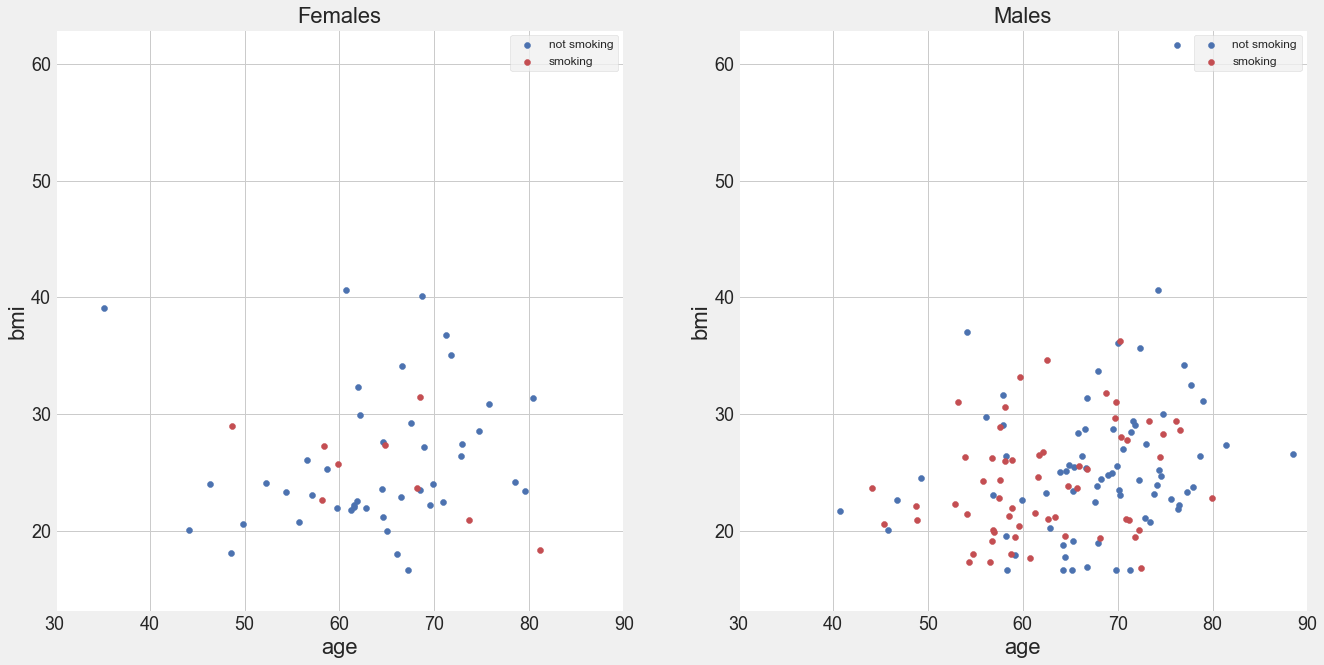

In [351]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
labels = []
inds_female = features_table[features_table['gender']==True].index
inds_male = features_table[features_table['gender']==False].index
for i,inds_gender,title in zip([0,1],[inds_female,inds_male],['Females','Males']):
    for label,l,c in zip(['not smoking', 'smoking'],[False,True],['b','r']):
        inds = features_table[features_table['currently_smoking']==l].index
        inds = list(set(inds).intersection(inds_gender))
        ax[i].scatter(features_table.loc[inds,'age'], features_table.loc[inds,'bmi'], label=label, color=c)
    ax[i].legend(prop={'size': 12})
    ax[i].set_title(title,fontdict={'fontsize': 22, 'fontweight': 'medium'})
    ax[i].set_xlabel('age', fontdict={'fontsize': 22, 'fontweight': 'medium'})
    ax[i].set_ylabel('bmi', fontdict={'fontsize': 22, 'fontweight': 'medium'})
    ax[i].set_xlim(30, 90)
    ax[i].set_ylim(13, 63)
    ax[i].set_facecolor('white')
#plt.savefig('covariate_common_support.png')

In [300]:
######################################## propensity scores ###############################################################

In [352]:
T = 'currently_smoking'
X = features_table.columns.drop([T])


In [353]:
# treatement (smoking) is correlated with gender
features_table.groupby(T)["gender"].mean()

currently_smoking
False    0.376068
True     0.132353
Name: gender, dtype: float64

In [354]:
# treatement (smoking) is A BIT correlated with age
features_table.groupby(T)["age"].mean()

currently_smoking
False    66.121368
True     62.644118
Name: age, dtype: float64

In [355]:
# treatement (smoking) is A BIT correlated with age
features_table.groupby(T)["bmi"].mean()

currently_smoking
False    25.644103
True     24.239265
Name: bmi, dtype: float64

In [356]:
# compute propensity scores
ps_model = LogisticRegression(C=1e6).fit(features_table[X], features_table[T])
features_table['propensity_score'] = ps_model.predict_proba(features_table[X])[:, 1]
features_table

,age,gender,bmi,currently_smoking,propensity_score
0,52.3,True,24.06,False,0.260854
3,79.9,False,22.77,True,0.284178
4,79.0,False,31.10,False,0.253888
7,71.0,False,27.76,True,0.357219
9,72.8,True,26.37,False,0.104494
...,...,...,...,...,...
383,53.2,False,31.02,True,0.561410
386,73.4,False,20.76,False,0.367676
387,74.5,False,26.31,True,0.324744
390,46.4,True,24.01,False,0.323486


Text(70, 0.6, 'Spearman=-0.57,\np-value=2.17e-17')

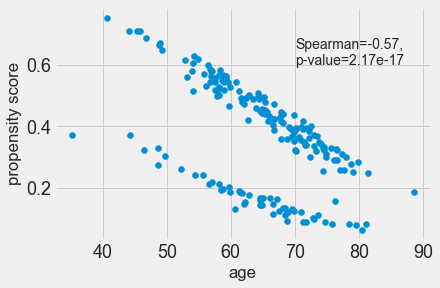

In [357]:
plt.scatter(features_table["age"], y=features_table["propensity_score"])
plt.xlabel('age')
plt.ylabel("propensity score")
corr,pval = spearmanr(features_table["age"], features_table["propensity_score"])
plt.text(70,0.6,'Spearman='+str(np.around(corr,2))+',\np-value='+str('{:.3g}'.format(pval)))


Text(0.1, 0.6, 'Spearman=-0.74,\np-value=8.93e-34')

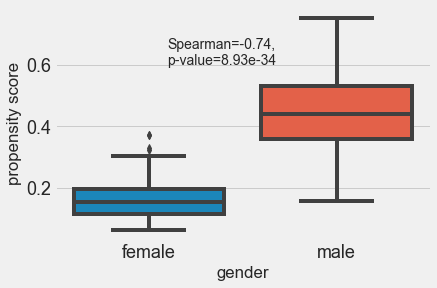

In [358]:
features_table['gender_name'] = ['female' if x==True else 'male' for x in features_table['gender']]
ax = sns.boxplot(x="gender_name", y="propensity_score", data=features_table)
ax.set(xlabel='gender', ylabel='propensity score')
features_table = features_table.drop(['gender_name'], axis=1)
corr,pval = spearmanr(features_table["gender"], features_table["propensity_score"])
plt.text(0.1,0.6,'Spearman='+str(np.around(corr,2))+',\np-value='+str('{:.3g}'.format(pval)))

Text(45, 0.6, 'Spearman=-0.36,\np-value=5.74e-07')

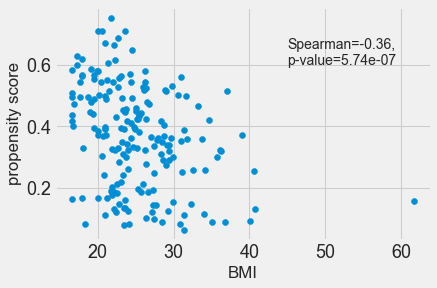

In [359]:
plt.scatter(features_table["bmi"], y=features_table["propensity_score"])
plt.xlabel('BMI')
plt.ylabel('propensity score')
corr,pval = spearmanr(features_table["bmi"], features_table["propensity_score"])
plt.text(45,0.6,'Spearman='+str(np.around(corr,2))+',\np-value='+str('{:.3g}'.format(pval)))

C:\Users\hadas\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


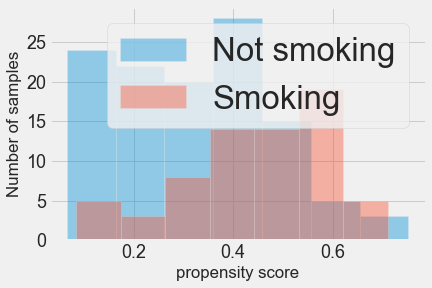

In [360]:
ax = sns.distplot(features_table.query("currently_smoking==0")["propensity_score"], kde=False, label="Not smoking")
ax = sns.distplot(features_table.query("currently_smoking==1")["propensity_score"], kde=False, label="Smoking")
ax.set(xlabel='propensity score', ylabel='Number of samples')
plt.legend()


In [361]:
# Divide to quintiles
ind_lst = features_table.sort_values(by='propensity_score', ascending=True).index
num_samp_in_each_quintile = int((len(features_table))/5)
print('num_samp_in_each_quintile:', num_samp_in_each_quintile)
T0_inds = set(features_table[features_table[T]==0].index)
T1_inds = set(features_table[features_table[T]==1].index)
T0_avgs = []
T1_avgs = []
for i in range(5):
    quin_inds = set(ind_lst[(num_samp_in_each_quintile*i):(num_samp_in_each_quintile*(i+1))])
    print('\nquintile', i+1, ':', len(T0_inds.intersection(quin_inds)), 'T0 samples, ',
          len(T1_inds.intersection(quin_inds)), 'T1 samples')
    T0_avgs.append(features_table.loc[T0_inds.intersection(quin_inds),'propensity_score'].mean())
    print('T0 average propensity score:', T0_avgs[-1:])
    T1_avgs.append(features_table.loc[T1_inds.intersection(quin_inds),'propensity_score'].mean())
    print('T1 average propensity score:', T1_avgs[-1:])


num_samp_in_each_quintile: 37

quintile 1 : 31 T0 samples,  6 T1 samples
T0 average propensity score: [0.13025549432768616]
T1 average propensity score: [0.13025529189085222]

quintile 2 : 27 T0 samples,  10 T1 samples
T0 average propensity score: [0.26592100930678897]
T1 average propensity score: [0.282303142459124]

quintile 3 : 27 T0 samples,  10 T1 samples
T0 average propensity score: [0.3731858116085403]
T1 average propensity score: [0.37682717379419794]

quintile 4 : 21 T0 samples,  16 T1 samples
T0 average propensity score: [0.4698526850247823]
T1 average propensity score: [0.47141385478927933]

quintile 5 : 11 T0 samples,  26 T1 samples
T0 average propensity score: [0.6045575052593202]
T1 average propensity score: [0.5874512869772726]


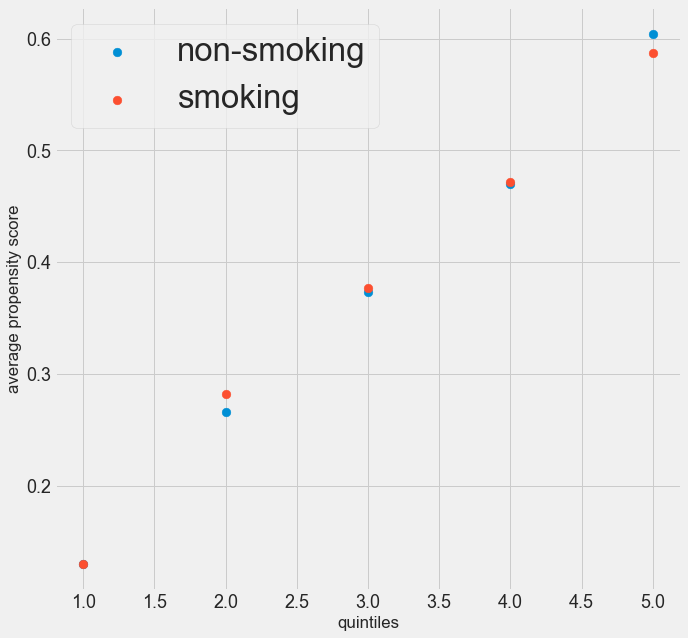

In [362]:
plt.figure(figsize=(10,10))
plt.scatter([1,2,3,4,5], T0_avgs, label='non-smoking', s=75)
plt.scatter([1,2,3,4,5], T1_avgs, label='smoking', s=75)
plt.xlabel('quintiles')
plt.ylabel('average propensity score')
plt.legend()

In [ ]:
######################################## IPW ###############################################################

In [312]:
def compute_ate_ipw(df, T, ps, Y, weight_t, weight_nt, return_y0_y1):
    y1 = sum(df[df[T]==True][Y]*weight_t)/len(df)
    y0 = sum(df[df[T]==False][Y]*weight_nt)/len(df)
    if return_y0_y1:
        return y1,y0,(y1-y0)
    else:
        return y1-y0
    
def compute_weight_and_ate_ipw(df, T, ps, Y, return_y0_y1):
    weight_t = 1/df[df[T]==True][ps]
    weight_nt = 1/(1-df[df[T]==False][ps])
    return compute_ate_ipw(df, T, ps, Y, weight_t, weight_nt, return_y0_y1)

In [313]:
Y = 'counts_per_million'
ps = 'propensity_score'

In [314]:
# IPW ATE table
ipw_ate_table = pd.DataFrame(index=diff_exp_genes)

weight_t = 1/features_table[features_table[T]==True][ps]
weight_nt = 1/(1-features_table[features_table[T]==False][ps])

ate_thr = 5

for g,gene in enumerate(diff_exp_genes):
    if (g+1)%25==0:
        print(g+1, 'genes done')
    features_table[Y] = list(counts_per_million.loc[gene,:])

    ipw_ate_table.loc[gene,'y1'],ipw_ate_table.loc[gene,'y0'],ipw_ate_table.loc[gene,'ate'] = compute_ate_ipw(
        features_table, T, ps, Y, weight_t, weight_nt, return_y0_y1=True)
    
    if np.abs(ipw_ate_table.loc[gene,'ate'])>=ate_thr:
        np.random.seed(60)
        # run 1000 bootstrap samples
        bootstrap_sample = 1000
        ates = Parallel(n_jobs=4)(delayed(compute_weight_and_ate_ipw)(features_table.sample(frac=1, replace=True), 
                                                                      T, ps, Y, False)
                                  for _ in range(bootstrap_sample))
        ates = np.array(ates)
        ipw_ate_table.loc[gene,'ate_mean'] = ates.mean()
        ipw_ate_table.loc[gene,'95_C.I._min'] = np.percentile(ates, 2.5)
        ipw_ate_table.loc[gene,'95_C.I._max'] = np.percentile(ates, 97.5)
        
ipw_ate_table = ipw_ate_table.sort_values(by='ate', ascending=False)

25 genes done
50 genes done
75 genes done
100 genes done
125 genes done
150 genes done
175 genes done
200 genes done
225 genes done
250 genes done
275 genes done
300 genes done
325 genes done
350 genes done
375 genes done
400 genes done
425 genes done


In [315]:
ipw_ate_table = add_gene_names(ipw_ate_table)
ipw_ate_table[['external_gene_name','ate']]


,external_gene_name,ate
ENSG00000087086.12,FTL,693.175958
ENSG00000164265.7,SCGB3A2,156.353423
ENSG00000165168.7,CYBB,130.971448
ENSG00000117984.11,CTSD,129.817826
ENSG00000030582.15,GRN,122.197291
...,...,...
ENSG00000142192.19,APP,-33.067793
ENSG00000196159.10,FAT4,-33.334128
ENSG00000213949.7,ITGA1,-48.867515
ENSG00000151914.16,DST,-114.453351


In [316]:
ipw_ate_table.loc[:,['external_gene_name', 'ate', 'ate_mean', '95_C.I._min', '95_C.I._max']]

,external_gene_name,ate,ate_mean,95_C.I._min,95_C.I._max
ENSG00000087086.12,FTL,693.175958,674.300330,-263.109728,1745.554047
ENSG00000164265.7,SCGB3A2,156.353423,153.355367,29.525076,301.829161
ENSG00000165168.7,CYBB,130.971448,127.013776,-38.322732,303.460413
ENSG00000117984.11,CTSD,129.817826,127.338622,-20.012178,294.591675
ENSG00000030582.15,GRN,122.197291,118.263198,-72.818679,335.317413
...,...,...,...,...,...
ENSG00000142192.19,APP,-33.067793,-37.317313,-197.468907,139.477505
ENSG00000196159.10,FAT4,-33.334128,-35.268950,-113.319733,50.611608
ENSG00000213949.7,ITGA1,-48.867515,-51.392376,-155.504299,65.626829
ENSG00000151914.16,DST,-114.453351,-129.862539,-744.146031,532.825505


In [317]:
ipw_file = '../results/normal_samples_only/ATE_by_IPW.txt'
#ipw_ate_table.to_csv(ipw_file)

In [321]:
################################### logit propensity score matching, with replacement ######################

In [322]:
# Euclidean distance, with caliper (knn)
features_table['logit_propensity_score'] = [logit(p) for p in features_table['propensity_score']]

caliper = np.std(features_table['logit_propensity_score']) * 0.2

print('Caliper (radius) is:', caliper)

knn = NearestNeighbors(n_neighbors=10, p=2, radius=caliper)
knn.fit(features_table[['logit_propensity_score']].to_numpy())

distances,indices = knn.kneighbors(features_table[['logit_propensity_score']].to_numpy(), n_neighbors=10)
distances

Caliper (radius) is: 0.16488832067719728


array([[0.        , 0.00417296, 0.00867584, ..., 0.08964724, 0.09122864,
        0.0954717 ],
       [0.        , 0.02647483, 0.02734439, ..., 0.08814299, 0.09488902,
        0.11770347],
       [0.        , 0.01256768, 0.0277718 , ..., 0.05902406, 0.10225892,
        0.12767628],
       ...,
       [0.        , 0.00444752, 0.00466094, ..., 0.02404045, 0.02991932,
        0.03157791],
       [0.        , 0.00108018, 0.0012936 , ..., 0.02978157, 0.03566044,
        0.03731903],
       [0.        , 0.00517933, 0.01335242, ..., 0.03445724, 0.04405705,
        0.0498692 ]])

In [ ]:
def save_11_matching(df, indices, newfilename):
    treatment_indices = []
    control_indices = []
    for i,row in zip(range(len(df)),df.index):
        # change nns indexes to features_table indexes, and preserving their order
        df_nn_inds = [df.index[x] for x in indices[i]]
        #print('features_table_nn_inds:', features_table_nn_inds)
        # keep only indices from the opposite group
        df_nn_inds_opp = list(set(df_nn_inds).intersection(set(df[df[T]!=df.loc[row,T]].index)))
        if df_nn_inds_opp:
            # find the closest neighbor (keep only relevant indices, in the same order)
            df_nn_inds = [x for x in df_nn_inds if x in df_nn_inds_opp]
            nn = df_nn_inds[0]
            if df.loc[row,T]:
                treatment_indices.append(row)
                control_indices.append(nn)
            else:
                control_indices.append(row)
                treatment_indices.append(nn)
    pd.DataFrame(columns=['control_indices','treatment_indices'],
                 data=np.transpose(np.array([control_indices,treatment_indices]))).to_csv(newfilename)

save_11_matching(df=features_table, indices=indices, 
                 newfilename='../results/normal_samples_only/ps_matching_with_replacement_11.txt')


In [323]:
def compute_ate_knn(df, indices, mode):
    # mode is "11" (1:1) or "1n" (1:n)
    ate_sum = 0
    count = 0
    for i,row in zip(range(len(df)),df.index):
        # change nns indexes to features_table indexes, and preserving their order
        df_nn_inds = [df.index[x] for x in indices[i]]
        #print('features_table_nn_inds:', features_table_nn_inds)
        # keep only indices from the opposite group
        df_nn_inds_opp = list(set(df_nn_inds).intersection(set(df[df[T]!=df.loc[row,T]].index)))
        if df_nn_inds_opp:
            # find the closest neighbor (keep only relevant indices, in the same order)
            df_nn_inds = [x for x in df_nn_inds if x in df_nn_inds_opp]
            if mode=='11':
                nn = df_nn_inds[0]
                count += 1
                if df.loc[row,T]:
                    ate_sum += df.loc[row,Y]-df.loc[nn,Y]
                else:
                    ate_sum += df.loc[nn,Y]-df.loc[row,Y]
            elif mode=='1n':
                count += 1
                if df.loc[row,T]:
                    ate_sum += df.loc[row,Y]-df.loc[df_nn_inds,Y].mean()
                else:
                    ate_sum += df.loc[df_nn_inds,Y].mean()-df.loc[row,Y]
    #print('Found matches to', count, 'samples')
    ate = ate_sum/count
    #print('ate:', ate)
    return count,ate

In [324]:
def compute_knn_and_ate(df, n_neighbors, p, radius, fit_on_cols, mode):
    knn = NearestNeighbors(n_neighbors=n_neighbors, p=p, radius=radius)
    knn.fit(df[fit_on_cols].to_numpy())
    distances,indices = knn.kneighbors(df[fit_on_cols].to_numpy(), n_neighbors=n_neighbors)    
    count,ate = compute_ate_knn(df, indices, mode)
    return ate


In [325]:
# logit of propensity score matching, 1:1 and 1:n, inside caliper, with replacement
ps_matching_ate_table_11 = pd.DataFrame(index=diff_exp_genes)
ps_matching_ate_table_1n = pd.DataFrame(index=diff_exp_genes)

for g,gene in enumerate(diff_exp_genes):
    if (g+1)%25==0:
        print(g+1, 'genes done')
    features_table[Y] = list(counts_per_million.loc[gene,:])
    ps_matching_ate_table_11.loc[gene,'count'],ps_matching_ate_table_11.loc[gene,'ate'] = compute_ate_knn(
        features_table, indices, mode='11')
    ps_matching_ate_table_1n.loc[gene,'count'],ps_matching_ate_table_1n.loc[gene,'ate'] = compute_ate_knn(
        features_table, indices, mode='1n')
    
    if np.abs(ps_matching_ate_table_11.loc[gene,'ate'])>=ate_thr:
        np.random.seed(88)
        # run 1000 bootstrap samples
        bootstrap_sample = 1000
        ates = Parallel(n_jobs=4)(delayed(compute_knn_and_ate)(features_table.sample(frac=1, replace=True).reset_index(), 
                                                               10, 2, caliper, ['logit_propensity_score'], '11')
                                  for _ in range(bootstrap_sample))
        ates = np.array(ates)
        ps_matching_ate_table_11.loc[gene,'ate_mean'] = ates.mean()
        ps_matching_ate_table_11.loc[gene,'95_C.I._min'] = np.percentile(ates, 2.5)
        ps_matching_ate_table_11.loc[gene,'95_C.I._max'] = np.percentile(ates, 97.5)
        
    if np.abs(ps_matching_ate_table_1n.loc[gene,'ate'])>=ate_thr:
        np.random.seed(88)
        # run 1000 bootstrap samples
        bootstrap_sample = 1000
        ates = Parallel(n_jobs=4)(delayed(compute_knn_and_ate)(features_table.sample(frac=1, replace=True).reset_index(), 
                                                               10, 2, caliper, ['logit_propensity_score'], '1n')
                                  for _ in range(bootstrap_sample))
        ates = np.array(ates)
        ps_matching_ate_table_1n.loc[gene,'ate_mean'] = ates.mean()
        ps_matching_ate_table_1n.loc[gene,'95_C.I._min'] = np.percentile(ates, 2.5)
        ps_matching_ate_table_1n.loc[gene,'95_C.I._max'] = np.percentile(ates, 97.5)
        
ps_matching_ate_table_11 = ps_matching_ate_table_11.sort_values(by='ate', ascending=False) 
ps_matching_ate_table_1n = ps_matching_ate_table_1n.sort_values(by='ate', ascending=False) 

25 genes done
50 genes done
75 genes done
100 genes done
125 genes done
150 genes done
175 genes done
200 genes done
225 genes done
250 genes done
275 genes done
300 genes done
325 genes done
350 genes done
375 genes done
400 genes done
425 genes done


In [326]:
ps_matching_ate_table_11 = add_gene_names(ps_matching_ate_table_11)
ps_matching_ate_table_11

,external_gene_name,count,ate,ate_mean,95_C.I._min,95_C.I._max
ENSG00000087086.12,FTL,180.0,574.062636,540.649337,148.405616,929.871004
ENSG00000164265.7,SCGB3A2,180.0,128.097921,131.690205,68.412045,199.620564
ENSG00000117984.11,CTSD,180.0,120.696079,107.803436,41.475187,173.449407
ENSG00000165168.7,CYBB,180.0,119.098728,112.842805,48.104090,183.182975
ENSG00000030582.15,GRN,180.0,106.307074,90.309364,28.928833,148.883742
...,...,...,...,...,...,...
ENSG00000196159.10,FAT4,180.0,-39.373664,-35.069200,-50.550523,-19.145218
ENSG00000142192.19,APP,180.0,-41.498113,-40.408698,-61.066907,-18.996126
ENSG00000213949.7,ITGA1,180.0,-57.245667,-53.263217,-82.514504,-21.815635
ENSG00000151914.16,DST,180.0,-165.396805,-156.561575,-264.310383,-37.441277


In [327]:
ps_matching_ate_table_1n = add_gene_names(ps_matching_ate_table_1n)
ps_matching_ate_table_1n

,external_gene_name,count,ate,ate_mean,95_C.I._min,95_C.I._max
ENSG00000087086.12,FTL,180.0,483.102143,499.765941,113.997454,894.644381
ENSG00000164265.7,SCGB3A2,180.0,125.955433,133.479092,68.777541,201.720792
ENSG00000117984.11,CTSD,180.0,103.480711,99.552865,36.814201,161.647442
ENSG00000165168.7,CYBB,180.0,99.950230,104.388874,37.646647,169.703934
ENSG00000030582.15,GRN,180.0,97.102291,86.036338,28.327511,142.222642
...,...,...,...,...,...,...
ENSG00000142192.19,APP,180.0,-36.270697,-38.341281,-60.663785,-16.402579
ENSG00000196159.10,FAT4,180.0,-36.295629,-33.885928,-50.308132,-17.473570
ENSG00000213949.7,ITGA1,180.0,-50.245316,-48.622720,-79.183117,-15.301245
ENSG00000151914.16,DST,180.0,-132.356293,-145.625369,-255.640571,-22.235107


In [328]:
ps_matching_ate_table_11_file = '../results/normal_samples_only/ATE_by_ps_match_11.txt'
#ps_matching_ate_table_11.to_csv(ps_matching_ate_table_11_file)

ps_matching_ate_table_1n_file = '../results/normal_samples_only/ATE_by_ps_match_1n.txt'
#ps_matching_ate_table_1n.to_csv(ps_matching_ate_table_1n_file)

In [329]:
######################################## covariate matching, with replacement ##############################

In [336]:
# normalize features to range 0-1
for col in ['age','bmi']:
    minn = np.min(features_table[col])
    maxx = np.max(features_table[col])
    features_table[col+'_norm'] = (features_table[col]-minn)/(maxx-minn)
    print(np.min(features_table[col+'_norm']),np.max(features_table[col+'_norm']))
features_table['gender_norm'] = features_table['gender'].astype(int)

knn = NearestNeighbors(n_neighbors=10, p=2)
knn.fit(features_table[['age_norm','gender_norm','bmi_norm']].to_numpy())

distances,indices = knn.kneighbors(features_table[['age_norm','gender_norm','bmi_norm']].to_numpy(), n_neighbors=10)
indices

0.0 1.0
0.0 1.0


array([[  0, 110, 168, ...,  68,  24,  80],
       [  1, 169,  69, ...,  21,  30,  96],
       [  2, 163,  37, ...,  61, 167, 159],
       ...,
       [182, 143,  30, ...,  56,  40, 159],
       [183, 165, 168, ...,   5,  36,   7],
       [184,  31, 156, ...,  40,  12, 177]], dtype=int64)

In [ ]:
save_11_matching(df=features_table, indices=indices, 
                 newfilename='../results/normal_samples_only/cov_matching_with_replacement_11.txt')


In [331]:
# greedy matching, 1:1 and 1:n, with replacement
cov_matching_ate_table_11 = pd.DataFrame(index=diff_exp_genes)
cov_matching_ate_table_1n = pd.DataFrame(index=diff_exp_genes)

for g,gene in enumerate(diff_exp_genes):
    if (g+1)%25==0:
        print(g+1, 'genes done')
    features_table[Y] = list(counts_per_million.loc[gene,:])
    cov_matching_ate_table_11.loc[gene,'count'],cov_matching_ate_table_11.loc[gene,'ate'] = compute_ate_knn(
        features_table, indices, mode='11')
    cov_matching_ate_table_1n.loc[gene,'count'],cov_matching_ate_table_1n.loc[gene,'ate'] = compute_ate_knn(
        features_table, indices, mode='1n')
    
    if np.abs(cov_matching_ate_table_11.loc[gene,'ate'])>=ate_thr:
        np.random.seed(88)
        # run 1000 bootstrap samples
        bootstrap_sample = 1000
        ates = Parallel(n_jobs=4)(delayed(compute_knn_and_ate)(features_table.sample(frac=1, replace=True).reset_index(), 
                                                               10, 2, 1, ['age_norm','gender_norm','bmi_norm'], '11')
                                  for _ in range(bootstrap_sample))
        ates = np.array(ates)
        cov_matching_ate_table_11.loc[gene,'ate_mean'] = ates.mean()
        cov_matching_ate_table_11.loc[gene,'95_C.I._min'] = np.percentile(ates, 2.5)
        cov_matching_ate_table_11.loc[gene,'95_C.I._max'] = np.percentile(ates, 97.5)
        
    if np.abs(cov_matching_ate_table_1n.loc[gene,'ate'])>=ate_thr:
        np.random.seed(88)
        # run 1000 bootstrap samples
        bootstrap_sample = 1000
        ates = Parallel(n_jobs=4)(delayed(compute_knn_and_ate)(features_table.sample(frac=1, replace=True).reset_index(), 
                                                               10, 2, 1, ['age_norm','gender_norm','bmi_norm'], '1n')
                                  for _ in range(bootstrap_sample))
        ates = np.array(ates)
        cov_matching_ate_table_1n.loc[gene,'ate_mean'] = ates.mean()
        cov_matching_ate_table_1n.loc[gene,'95_C.I._min'] = np.percentile(ates, 2.5)
        cov_matching_ate_table_1n.loc[gene,'95_C.I._max'] = np.percentile(ates, 97.5)
        
cov_matching_ate_table_11 = cov_matching_ate_table_11.sort_values(by='ate', ascending=False) 
cov_matching_ate_table_1n = cov_matching_ate_table_1n.sort_values(by='ate', ascending=False) 

25 genes done
50 genes done
75 genes done
100 genes done
125 genes done
150 genes done
175 genes done
200 genes done
225 genes done
250 genes done
275 genes done
300 genes done
325 genes done
350 genes done
375 genes done
400 genes done
425 genes done


In [332]:
cov_matching_ate_table_11 = add_gene_names(cov_matching_ate_table_11)
cov_matching_ate_table_11

,external_gene_name,count,ate,ate_mean,95_C.I._min,95_C.I._max
ENSG00000087086.12,FTL,178.0,369.842974,393.874163,-0.410228,833.810171
ENSG00000164265.7,SCGB3A2,178.0,113.492636,124.579369,61.856160,188.235239
ENSG00000165168.7,CYBB,178.0,87.499870,94.639340,24.662884,166.466811
ENSG00000038945.13,MSR1,178.0,79.145750,76.456355,17.418574,134.108194
ENSG00000107798.16,LIPA,178.0,75.944898,75.929692,19.158659,137.652597
...,...,...,...,...,...,...
ENSG00000196159.10,FAT4,178.0,-29.037244,-28.481063,-47.057567,-9.146948
ENSG00000144724.17,PTPRG,178.0,-29.583296,-30.771102,-46.064216,-16.504682
ENSG00000142192.19,APP,178.0,-36.732965,-37.490659,-65.915184,-10.900487
ENSG00000151914.16,DST,178.0,-121.954571,-135.621847,-260.125669,-4.605720


In [333]:
cov_matching_ate_table_1n = add_gene_names(cov_matching_ate_table_1n)
cov_matching_ate_table_1n

,external_gene_name,count,ate,ate_mean,95_C.I._min,95_C.I._max
ENSG00000087086.12,FTL,178.0,419.236599,439.379571,59.245834,856.131825
ENSG00000164265.7,SCGB3A2,178.0,130.700660,129.205919,67.093887,186.754738
ENSG00000165168.7,CYBB,178.0,96.150954,102.261688,36.858210,165.270176
ENSG00000117984.11,CTSD,178.0,88.055425,88.245759,25.775729,153.828794
ENSG00000107798.16,LIPA,178.0,86.848640,81.925772,26.428759,144.150039
...,...,...,...,...,...,...
ENSG00000196159.10,FAT4,178.0,-36.334357,-32.014421,-49.730704,-14.429155
ENSG00000142192.19,APP,178.0,-48.932417,-44.208135,-69.032695,-20.841558
ENSG00000213949.7,ITGA1,178.0,-51.856146,-47.720422,-82.059914,-14.456162
ENSG00000151914.16,DST,178.0,-162.996734,-152.055060,-277.872766,-27.860403


In [334]:
cov_matching_ate_table_11_file = '../results/normal_samples_only/ATE_by_cov_match_11.txt'
#cov_matching_ate_table_11.to_csv(cov_matching_ate_table_11_file)

cov_matching_ate_table_1n_file = '../results/normal_samples_only/ATE_by_cov_match_1n.txt'
#cov_matching_ate_table_1n.to_csv(cov_matching_ate_table_1n_file)